In [1]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py
import datetime as dt

#math
import numpy as np
import math
import scipy.fftpack
from scipy import signal
import scipy.interpolate as interpolate
from scipy import integrate
pd.TimeSeries = pd.Series 

#gps
from geopy import distance

#plots
import pylab as plt
import matplotlib.pyplot as plt
import matplotlib.animation as animation  

In [2]:
def padarray(A, size):
    t = size - len(A)
    return np.pad(A, pad_width=(0, t), mode='constant')

In [3]:
#ROS TIME IS ALREADY WITH REFERENCE FROM EPOCH HENCE NO NEED TO SUBTRACT FROM 1970
def epoch_setup(df):
    #a=dt.datetime.utcfromtimestamp(0)
    #dtx = []
    #converting timestamp to datetime format; subtracting from epoch and converting back to seconds
    #for i in range (len(df.time)):
    #    dtx.append((dt.datetime.fromtimestamp(df.time[i])-a).total_seconds()) 
    #df.insert(1,'epoch',dtx)
    sync_time = df.time-df.time[0]
    df.insert(1,'sync_time',sync_time)
    return df

### Stationary Wind Bag B

In [4]:
fname='/home/ecc/data/DesertDataOct/StationeryWind/20201020_172919_windy_b_data.hdf'
wind_df=pd.read_hdf(fname)
wind_df.keys()

Index(['millis', 'lat', 'lon', 'gps_time', 'gps_date', 'wind', 'gps_date_str',
       'year', 'month', 'day', 'gps_time_str', 'hour', 'minute', 'second',
       'time_epoch', 'S2', 'D', 'U', 'V', 'W', 'T', 'H', 'AD', 'MD'],
      dtype='object')

In [5]:
sync_time0 = wind_df.time_epoch-wind_df.time_epoch[0]
wind_df.insert(1,'sync_time',sync_time0)


In [6]:
#integration of U vector
u=[]
for i in range(len(wind_df.U)-1):
    u.append(np.trapz([wind_df.U[i],wind_df.U[i+1]],[wind_df.time_epoch[i], wind_df.time_epoch[i+1]]))
#integration of V vector
v=[]
for i in range(len(wind_df.V)-1):
    v.append(np.trapz([wind_df.V[i],wind_df.V[i+1]],[wind_df.time_epoch[i], wind_df.time_epoch[i+1]]))
    


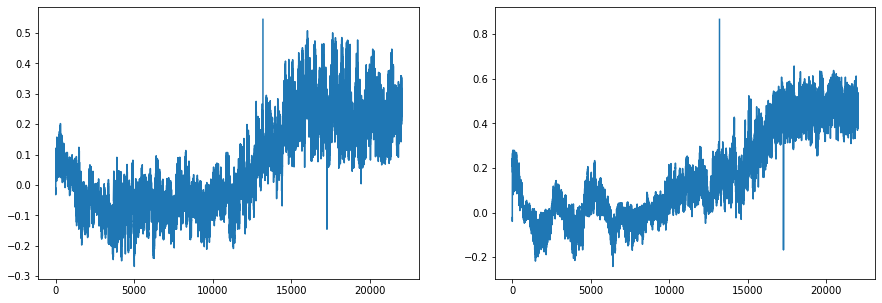

In [7]:
fig,(ax_u,ax_v)=plt.subplots(1,2,figsize=(15,5))
ax_u.plot(wind_df.sync_time[:220329], u)
ax_v.plot(wind_df.sync_time[:220329], v)

In [8]:
position_U = integrate.cumtrapz(wind_df.U[1:],wind_df.time_epoch[1:], axis=0) 
position_V = integrate.cumtrapz(wind_df.V[1:],wind_df.time_epoch[1:], axis=0) 
positions = integrate.cumtrapz([wind_df.U[1:],wind_df.V[1:]], wind_df.time_epoch[1:], axis=1) #comprises both U & V

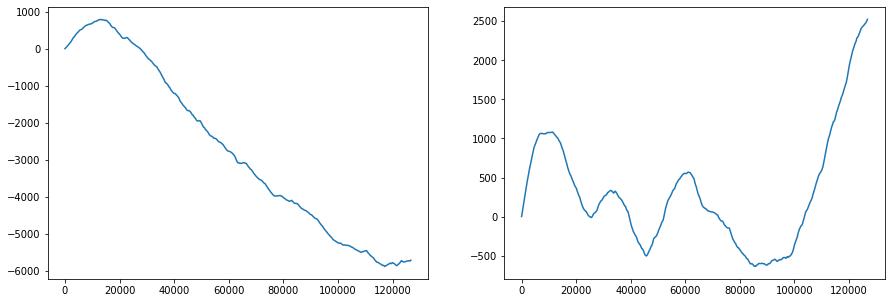

In [9]:
fig,(ax_pos_u,ax_pos_v)=plt.subplots(1,2,figsize=(15,5))
ax_pos_u.plot(position_U)
ax_pos_v.plot(position_V)

In [10]:
#padding zeros to match length
X = padarray(position_U, 220330)
Y = padarray(position_V, 220330)

In [11]:
#adding position data to the main df
wind_df['position_u'] = X
wind_df['position_v'] = Y

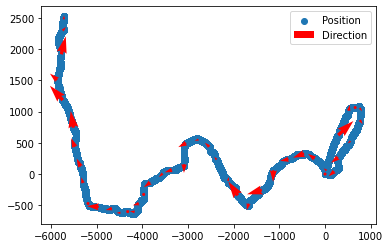

In [12]:
plt.scatter(positions[0],positions[1], label='Position')
plt.quiver(positions[0,::3000], positions[1,::3000],
    wind_df.U[1:220329:3000], wind_df.V[1:220329:3000], color='red',
    width=0.01, label='Direction')
plt.legend()

In [13]:
#TODO: ANIMATION - UPDATE WITH RESPECT TO TIME STAMP or a dt

# %matplotlib notebook
# import seaborn as sns
# plt.style.use('seaborn-pastel')

# fig = plt.figure(figsize=(10,4))
# ax=plt.axes(xlim=(-7000, 1000), ylim=(-1000, 2600))
# line, = ax.plot([], [])

# def init():
#     line.set_data([], [])
#     return line,

# def animate(i):   
#     x = positions[0]
#     y = positions[1]
#     line.set_data(x, y)
#     return line,

    
# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=200, interval=20, blit=True)
# anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

### Setup Bags - BAG01 - Source Location

In [14]:
#dfbag01 = hp.import_csv("~/data/DesertDataOct/Run01/OctoberRun01Bag01.csv") 
dfbag01 = hp.import_csv("~/data/DesertDataOct/Run01/OctoberRun01Bag01.csv")

In [15]:
epoch_setup(dfbag01)

,time,sync_time,_analog_output_data,_trisonica_direction,_trisonica_header_frame_id,_trisonica_header_seq,_trisonica_header_stamp_nsecs,_trisonica_header_stamp_secs,_trisonica_humidity,_trisonica_northsouth,...,_ublox_gps_fix_position_covariance_2,_ublox_gps_fix_position_covariance_3,_ublox_gps_fix_position_covariance_4,_ublox_gps_fix_position_covariance_5,_ublox_gps_fix_position_covariance_6,_ublox_gps_fix_position_covariance_7,_ublox_gps_fix_position_covariance_8,_ublox_gps_fix_position_covariance_type,_ublox_gps_fix_status_service,_ublox_gps_fix_status_status
0,1.603220e+09,0.00,0.671380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.603220e+09,0.01,NaN,19.0,NaN,287.0,575581073.0,1.603220e+09,35.599998,-0.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.603220e+09,0.01,0.670128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.603220e+09,0.01,0.669503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.603220e+09,0.02,0.669816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73438,1.603220e+09,299.75,1.201919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73439,1.603220e+09,299.75,1.175017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73440,1.603220e+09,299.76,NaN,111.0,NaN,12277.0,326195001.0,1.603220e+09,36.200001,-1.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73441,1.603220e+09,299.76,1.162192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
dfbag01=dfbag01.interpolate()

Text(0, 0.5, 'Latitude')

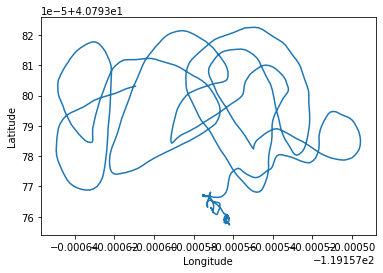

In [17]:
# dfbag01.keys()
fig = plt.figure()

ax = fig.add_subplot(111)

ax.plot(dfbag01._ublox_gps_fix_longitude, dfbag01._ublox_gps_fix_latitude)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

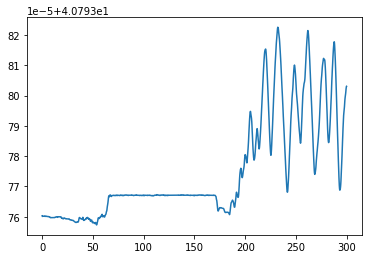

In [18]:
plt.plot(dfbag01.sync_time,dfbag01._ublox_gps_fix_latitude)

In [19]:
query = 'sync_time > 75 and sync_time < 150'
df_gps= dfbag01.query(query)

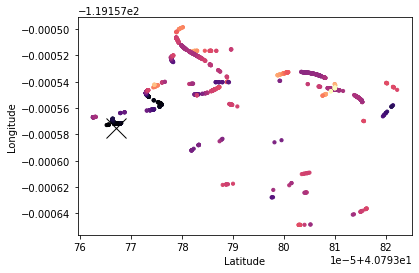

In [20]:
source_location_lat=df_gps._ublox_gps_fix_latitude.mean()
source_location_long=df_gps._ublox_gps_fix_longitude.mean()
source_location=[source_location_lat, source_location_long]
source_location

query = '_analog_output_data > 5 and _analog_output_data <= 10'
df_tmp = dfbag01.query(query)

fig_odor_gps = plt.figure()
ax_odor_gps_filtered = fig_odor_gps.add_subplot(111)
ax_odor_gps_filtered.scatter(df_tmp._ublox_gps_fix_latitude, df_tmp._ublox_gps_fix_longitude, c=df_tmp._ublox_gps_fix_altitude, s=10, cmap='magma')
ax_odor_gps_filtered.set_xlabel('Latitude')
ax_odor_gps_filtered.set_ylabel('Longitude')

plt.plot([40.79376709443614], [-119.15757512132207], marker='x', markersize=20, color="black")

### Setup Bags - BAG02 - Analysis

In [21]:
dfbag02 = hp.import_csv("~/data/DesertDataOct/Run02/OctoberRun02Bag0.csv") 

In [22]:
epoch_setup(dfbag02)

,time,sync_time,_analog_output_data,_trisonica_direction,_trisonica_header_frame_id,_trisonica_header_seq,_trisonica_header_stamp_nsecs,_trisonica_header_stamp_secs,_trisonica_humidity,_trisonica_northsouth,...,_ublox_gps_fix_position_covariance_2,_ublox_gps_fix_position_covariance_3,_ublox_gps_fix_position_covariance_4,_ublox_gps_fix_position_covariance_5,_ublox_gps_fix_position_covariance_6,_ublox_gps_fix_position_covariance_7,_ublox_gps_fix_position_covariance_8,_ublox_gps_fix_position_covariance_type,_ublox_gps_fix_status_service,_ublox_gps_fix_status_status
0,1.603221e+09,0.00,0.636031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.603221e+09,0.00,0.635718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.603221e+09,0.00,NaN,256.0,NaN,1.0,554316043.0,1.603221e+09,34.799999,1.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.603221e+09,0.01,0.634467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.603221e+09,0.01,0.636031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73433,1.603221e+09,299.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.0001,2.0,3.0,2.0
73434,1.603221e+09,299.73,0.593488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73435,1.603221e+09,299.73,NaN,135.0,NaN,11990.0,280133008.0,1.603221e+09,32.000000,-1.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73436,1.603221e+09,299.73,0.592237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Interpolation Method Comparison

In [147]:
#compare cubic, spline and linear interpolation
odor_concentration_cubic=dfbag02['_analog_output_data'].interpolate(method='cubic', order=2)
odor_concentration_spline=dfbag02['_analog_output_data'].interpolate(method='spline', order=2)
odor_concentration_linear=dfbag02['_analog_output_data'].interpolate(method='linear')

odor_concentration_spline_clipped = np.clip(odor_concentration_spline, a_min = 0.6, a_max = 10.4) 

In [148]:
df_interpolation = pd.DataFrame()

In [149]:
df_interpolation.insert(0,'time',dfbag02.sync_time)
df_interpolation.insert(1,'odor_concentration_cubic',odor_concentration_cubic)
df_interpolation.insert(2,'odor_concentration_spline',odor_concentration_spline)
df_interpolation.insert(3,'odor_concentration_linear',odor_concentration_linear)

In [150]:
df_interpolation

,time,odor_concentration_cubic,odor_concentration_spline,odor_concentration_linear
0,0.00,0.636031,0.636031,0.636031
1,0.00,0.635718,0.635718,0.635718
2,0.00,0.634523,0.662066,0.635093
3,0.01,0.634467,0.634467,0.634467
4,0.01,0.636031,0.636031,0.636031
...,...,...,...,...
73433,299.72,0.594123,0.579049,0.593019
73434,299.73,0.593488,0.593488,0.593488
73435,299.73,0.592781,0.551855,0.592862
73436,299.73,0.592237,0.592237,0.592237


In [151]:
df_interpolation.insert(4,'odor_concentration',odor_concentration_spline_clipped)

(75.0, 300.0)

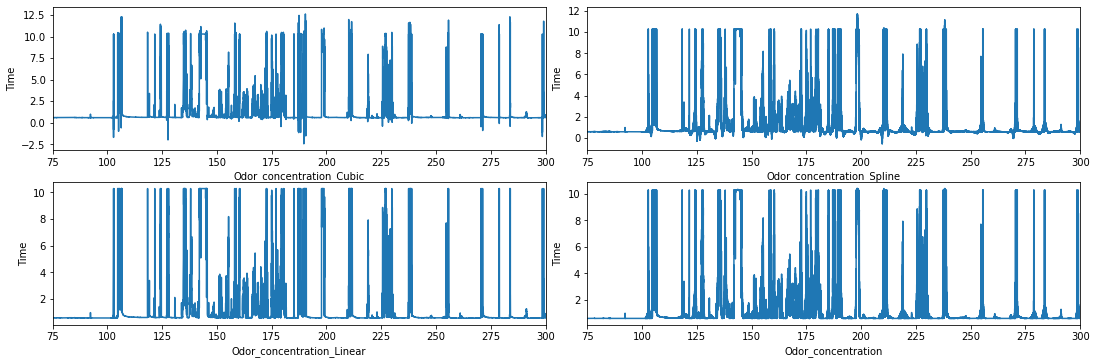

In [152]:
fig,((ax_1,ax_2),(ax_3, ax_4))=plt.subplots(2,2,figsize=(15,5))
fig.tight_layout()

ax_1.plot(df_interpolation.time, df_interpolation.odor_concentration_cubic)
ax_1.set_xlabel('Odor_concentration_Cubic')
ax_1.set_ylabel('Time')
ax_1.set_xlim(75,300)


ax_2.plot(df_interpolation.time, df_interpolation.odor_concentration_spline)
ax_2.set_xlabel('Odor_concentration_Spline')
ax_2.set_ylabel('Time')
ax_2.set_xlim(75,300)

ax_3.plot(df_interpolation.time, df_interpolation.odor_concentration_linear)
ax_3.set_xlabel('Odor_concentration_Linear')
ax_3.set_ylabel('Time')
ax_3.set_xlim(75,300)

ax_4.plot(df_interpolation.time, df_interpolation.odor_concentration)
ax_4.set_xlabel('Odor_concentration')
ax_4.set_ylabel('Time')
ax_4.set_xlim(75,300)

In [153]:
# dfbag02_tmp=dfbag02
# dfbag02_tmp.insert(3,'odor_concentration',df_interpolation.odor_concentration)
# dfbag02_tmp.set_index('odor_concentration', inplace=True)
# dfbag02_tmp.interpolate(method='index', inplace=True)
# dfbag02_tmp.reset_index(inplace=True)

In [28]:
dfbag02=dfbag02.interpolate(method='linear')

Text(0, 0.5, 'Latitude')

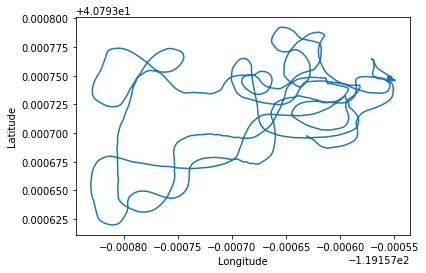

In [29]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.plot(dfbag02._ublox_gps_fix_longitude, dfbag02._ublox_gps_fix_latitude)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [31]:
dfbag02.time[0]

1603221192.55

In [33]:
dfbag02.time[73437]

1603221492.29

In [68]:
wind_df_bag02 = wind_df.loc[(wind_df.time_epoch >= 1603221192.55) & (wind_df.time_epoch <= 1603221492.29)]

In [103]:
query = ' _analog_output_data >= 7'
dfbag02_tmp = dfbag02.query(query)

Text(0, 0.5, 'Longitude')

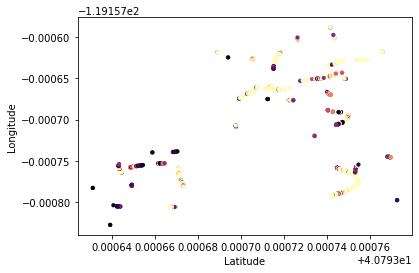

In [104]:
fig_odor_gps = plt.figure()
ax= fig_odor_gps.add_subplot(111)
cmap = plt.cm.get_cmap("magma", 10)
#ax.scatter(wind_df_bag02.position_u,wind_df_bag02.position_v)
ax.scatter(dfbag02_tmp._ublox_gps_fix_latitude, dfbag02_tmp._ublox_gps_fix_longitude, c=dfbag02_tmp._analog_output_data, s=10, cmap='magma')
#ax.plot(dfbag02_tmp._ublox_gps_fix_latitude, dfbag02_tmp._ublox_gps_fix_longitude)
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

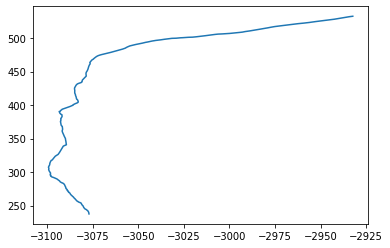

In [82]:
plt.plot(wind_df_bag02.position_u,wind_df_bag02.position_v)

(200.0, 600.0)

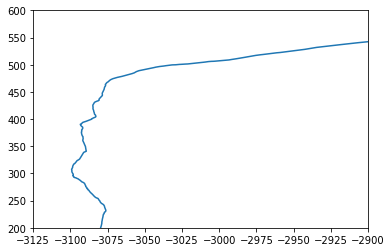

In [91]:
plt.plot(wind_df.position_u, wind_df.position_v)
plt.xlim(-3125, -2900)
plt.ylim(200,600)

31.988526614973562


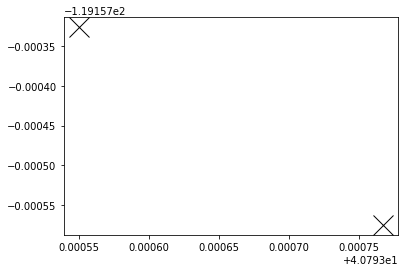

In [65]:
#distance between windstation and odor source
plt.plot([40.79355], [-119.157326], marker='x', markersize=20, color="black")
plt.plot([40.79376709443614], [-119.15757512132207], marker='x', markersize=20, color="black")

#5 inches; 0.127 meters; 12.7 cm

from geopy import distance
coords_1 = (40.79355, -119.157326)
coords_2 = (40.79376709443614, -119.15757512132207)

print (distance.geodesic(coords_1, coords_2).meters)

In [ ]:
#TEST
# A = [1,2,3,4,5,6,7]
# T = [1,2,3,4,5,6,7]
# B = []
# C = []
# D= []
# C = integrate.cumtrapz(A,T)
# for i in range(len(A)-1):
#     B.append(np.trapz([A[i],A[i+1]],[T[i], T[i+1]]))
# print(B)
# print(C)

#TEST2
# arr1 =[]
# arr2 =[]
# for i in range(len(y)):
#     if i==0:
#         arr1.append(0)
#     else:
#         arr1.append(y[i]+arr1[i-1])

# for i in range(len(z)):
#     if i==0:
#         arr2.append(0)
#     else:
#         arr2.append(z[i]+arr2[i-1])

# #arr1 = U zonal velocity ; eastwest
# #arr2 = V meridian velocity; Northsouth
# particle = list(zip(u,v))
# particle
# plt.plot(particle)

#TEST3
#without for loop integration using cumsum ; dt selected from averaging the difference of the time stamps
# a=np.cumsum(wind_df[1:].U*dt)
# b=np.cumsum(wind_df[1:].V*dt)

# fig, (ax_eastwest, ax_northsouth) = plt.subplots(1,2,figsize=(15,5))

# ax_eastwest.plot(a)
# ax_northsouth.plot(b)